In [1]:
# Cài đặt các thư viện cần thiết (nếu chưa có)
# !pip install pandas seaborn matplotlib undetected-chromedriver openpyxl scikit-learn adjustText

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import undetected_chromedriver as uc
import time
import os
from functools import reduce
from adjustText import adjust_text
import warnings


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # Hiện tất cả cột

sns.set_theme(style="whitegrid")

In [2]:
def setup_driver():
    options = uc.ChromeOptions()
    options.headless = False 
    # Thay version_main=142 bằng version Chrome máy bạn nếu cần
    driver = uc.Chrome(options=options, version_main=142) 
    driver.minimize_window()
    return driver

def get_data_by_category(driver, category, season, comp_id, comp_name):
    if category == 'stats':
        url = f"https://fbref.com/en/comps/{comp_id}/{season}/{season}-{comp_name}-Stats"
    else:
        url = f"https://fbref.com/en/comps/{comp_id}/{season}/{category}/{season}-{comp_name}-Stats"
    
    print(f"Retrieving: {category.upper()}...")
    driver.get(url)
    time.sleep(10) # Đợi tải
    driver.execute_script("window.scrollTo(0, 600);")
    time.sleep(2)
    
    try:
        html = driver.page_source
        dfs = pd.read_html(html)
        target_df = None
        max_rows = 0
        
        # Logic tìm bảng to nhất có chứa cột Player
        for table in dfs:
            cols = [str(c).lower() for c in table.columns.values]
            if any("player" in c for c in cols):
                if len(table) > max_rows:
                    max_rows = len(table)
                    target_df = table
        
        if target_df is not None:
            # Xử lý tên cột MultiIndex
            if isinstance(target_df.columns, pd.MultiIndex):
                new_cols = []
                for col in target_df.columns.values:
                    if "Unnamed" in str(col[0]):
                        new_cols.append(str(col[1]))
                    else:
                        new_cols.append(f"{col[0]}_{col[1]}")
                target_df.columns = new_cols
            
            # Chuẩn hóa tên cột Player
            for col in target_df.columns:
                if "player" in str(col).lower():
                    target_df = target_df.rename(columns={col: 'Player'})
                    break

            # Lọc rác
            target_df = target_df[target_df['Player'] != 'Player']
            cols_to_drop = ['Rk', 'Matches']
            target_df = target_df.drop(columns=[c for c in cols_to_drop if c in target_df.columns])
            
            # Đổi tên cột 90s để tránh trùng khi merge
            if '90s' in target_df.columns:
                target_df = target_df.rename(columns={'90s': f'90s_{category}'})
                
            return target_df
        return None
    except Exception as e:
        print(f"Error {category}: {e}")
        return None

def run_scraping():
    driver = setup_driver()
    SEASON = "2024-2025"
    categories = ["stats", "shooting", "passing", "defense", "possession", "misc"]
    all_dfs = []
    
    try:
        for cat in categories:
            df = get_data_by_category(driver, cat, SEASON, "9", "Premier-League")
            if df is not None:
                # Đổi tên cột (thêm prefix) trừ các cột định danh
                cols_id = ['Player', 'Squad', 'Nation', 'Pos', 'Age', 'Born']
                new_names = {}
                for c in df.columns:
                    if c not in cols_id and not c.startswith('90s_'):
                        new_names[c] = f"{cat}_{c}"
                df = df.rename(columns=new_names)
                all_dfs.append(df)
            time.sleep(5)
            
        # Gộp dữ liệu
        if all_dfs:
            final_df = reduce(lambda l, r: pd.merge(l, r, on=['Player', 'Squad', 'Nation', 'Pos', 'Age', 'Born'], how='outer'), all_dfs)
            return final_df
    finally:
        driver.quit()
    return None

In [ ]:
# --- CẤU HÌNH CHẠY ---
RUN_SCRAPING = False  # Đổi thành True nếu bạn muốn cào lại từ đầu
FILE_NAME = "FBref_Premier-League_2024-2025_Full_Merged.xlsx"

if RUN_SCRAPING:
    print("🚀 Đang bắt đầu cào dữ liệu...")
    df_raw = run_scraping()
    if df_raw is not None:
        df_raw.to_excel(FILE_NAME, index=False)
        print("✅ Đã cào và lưu xong!")
else:
    print("⏩ Bỏ qua bước cào dữ liệu. Đang đọc file có sẵn...")
    if os.path.exists(FILE_NAME):
        df_raw = pd.read_excel(FILE_NAME)
        print("✅ Đã đọc file thành công!")
    else:
        print("❌ Chưa có file dữ liệu! Hãy đổi RUN_SCRAPING = True")

# Xem thử 5 dòng đầu
if 'df_raw' in locals():
    display(df_raw.head())          

⏩ Bỏ qua bước cào dữ liệu. Đang đọc file có sẵn...
✅ Đã đọc file thành công!


,Player,Nation,Pos,Squad,Age,Born,90s_shooting,shooting_Standard_Gls,shooting_Standard_Sh,shooting_Standard_SoT,shooting_Standard_SoT%,shooting_Standard_Sh/90,shooting_Standard_SoT/90,shooting_Standard_G/Sh,shooting_Standard_G/SoT,shooting_Standard_Dist,shooting_Standard_FK,shooting_Standard_PK,shooting_Standard_PKatt,shooting_Expected_xG,shooting_Expected_npxG,shooting_Expected_npxG/Sh,shooting_Expected_G-xG,shooting_Expected_np:G-xG,90s_passing,passing_Total_Cmp,passing_Total_Att,passing_Total_Cmp%,passing_Total_TotDist,passing_Total_PrgDist,passing_Short_Cmp,passing_Short_Att,passing_Short_Cmp%,passing_Medium_Cmp,passing_Medium_Att,passing_Medium_Cmp%,passing_Long_Cmp,passing_Long_Att,passing_Long_Cmp%,passing_Ast,passing_xAG,passing_Expected_xA,passing_Expected_A-xAG,passing_KP,passing_1/3,passing_PPA,passing_CrsPA,passing_PrgP,90s_passing_types,passing_types_Att,passing_types_Pass Types_Live,passing_types_Pass Types_Dead,passing_types_Pass Types_FK,passing_types_Pass Types_TB,passing_types_Pass Types_Sw,passing_types_Pass Types_Crs,passing_types_Pass Types_TI,passing_types_Pass Types_CK,passing_types_Corner Kicks_In,passing_types_Corner Kicks_Out,passing_types_Corner Kicks_Str,passing_types_Outcomes_Cmp,passing_types_Outcomes_Off,passing_types_Outcomes_Blocks,90s_gca,gca_SCA_SCA,gca_SCA_SCA90,gca_SCA Types_PassLive,gca_SCA Types_PassDead,gca_SCA Types_TO,gca_SCA Types_Sh,gca_SCA Types_Fld,gca_SCA Types_Def,gca_GCA_GCA,gca_GCA_GCA90,gca_GCA Types_PassLive,gca_GCA Types_PassDead,gca_GCA Types_TO,gca_GCA Types_Sh,gca_GCA Types_Fld,gca_GCA Types_Def,90s_defense,defense_Tackles_Tkl,defense_Tackles_TklW,defense_Tackles_Def 3rd,defense_Tackles_Mid 3rd,defense_Tackles_Att 3rd,defense_Challenges_Tkl,defense_Challenges_Att,defense_Challenges_Tkl%,defense_Challenges_Lost,defense_Blocks_Blocks,defense_Blocks_Sh,defense_Blocks_Pass,defense_Int,defense_Tkl+Int,defense_Clr,defense_Err,90s_possession,possession_Touches_Touches,possession_Touches_Def Pen,possession_Touches_Def 3rd,possession_Touches_Mid 3rd,possession_Touches_Att 3rd,possession_Touches_Att Pen,possession_Touches_Live,possession_Take-Ons_Att,possession_Take-Ons_Succ,possession_Take-Ons_Succ%,possession_Take-Ons_Tkld,possession_Take-Ons_Tkld%,possession_Carries_Carries,possession_Carries_TotDist,possession_Carries_PrgDist,possession_Carries_PrgC,possession_Carries_1/3,possession_Carries_CPA,possession_Carries_Mis,possession_Carries_Dis,possession_Receiving_Rec,possession_Receiving_PrgR,90s_misc,misc_Performance_CrdY,misc_Performance_CrdR,misc_Performance_2CrdY,misc_Performance_Fls,misc_Performance_Fld,misc_Performance_Off,misc_Performance_Crs,misc_Performance_Int,misc_Performance_TklW,misc_Performance_PKwon,misc_Performance_PKcon,misc_Performance_OG,misc_Performance_Recov,misc_Aerial Duels_Won,misc_Aerial Duels_Lost,misc_Aerial Duels_Won%
0,Aaron Cresswell,eng ENG,DF,West Ham,34.0,1989.0,9.2,0,5,0,0.0,0.55,0.00,0.00,NaN,23.8,2,0,0,0.2,0.2,0.05,-0.2,-0.2,9.2,504,610,82.6,9299,3625,229,249,92.0,212,241,88.0,58,107,54.2,0,1.3,1.9,-1.3,9,52,5,2,36,9.2,610,511,98,33,1,5,36,52,13,11,2,0,504,1,10,9.2,15,1.64,7,8,0,0,0,0,0,0.00,0,0,0,0,0,0,9.2,11,7,5,5,1,9,11,81.8,2,9,4,5,8,19,37,0,9.2,687,45,270,328,94,2,687,2,1,50.0,1,50.0,291,1102,526,6,8,0,4,0,437,4,9.2,3,0,0,4,2,0,36,8,7,0,0,0,36,7,7,50.0
1,Aaron Ramsdale,eng ENG,GK,Southampton,26.0,1998.0,30.0,0,0,0,NaN,0.00,0.00,NaN,NaN,NaN,0,0,0,0.0,0.0,NaN,0.0,0.0,30.0,774,1223,63.3,21949,16992,209,210,99.5,302,313,96.5,257,686,37.5,0,0.0,0.1,0.0,0,36,1,0,0,30.0,1223,918,298,108,0,4,0,0,0,0,0,0,774,7,1,30.0,3,0.10,2,1,0,0,0,0,0,0.00,0,0,0,0,0,0,30.0,0,0,0,0,0,0,3,0.0,3,0,0,0,2,2,10,3,30.0,1314,946,1286,32,0,0,1314,0,0,NaN,0,NaN,786,4017,2349,0,0,0,3,0,702,0,30.0,2,0,0,1,4,0,0,2,0,0,0,0,23,6,0,100.0
2,Aaron Wan-Bissaka,cd COD,DF,West Ham,26.0,1997.0,35.0,2,16,5,31.3,0.46,0.14,0.13,0.40,15.1,0,0,0,1.2,1.2,0.07,0.8,0.8,35.0,1472,1815,81.1,20696,7523,953,1056,90.2,449,550,81.6,48,105,45.7,5,3.5,2.8,1.5,33,94,35,11,149,35.0,1815,1568,243,11,5,1

In [4]:
def clean_data(df):
    df = df.copy()
    
    # 1. Xử lý Quốc tịch (eng ENG -> ENG)
    if 'Nation' in df.columns:
        df['Nation'] = df['Nation'].astype(str).str.split(' ').str.get(-1).replace('nan', 'Unknown')
        
    # 2. Xử lý Vị trí (DF,MF -> DF)
    if 'Pos' in df.columns:
        df['Pos'] = df['Pos'].astype(str).str.split(',').str.get(0)
        
    # 3. Xử lý Tuổi (24-150 -> 24)
    if 'Age' in df.columns:
        df['Age'] = df['Age'].astype(str).str[:2]
        df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
        
    # 4. Chuyển đổi số liệu (String -> Float) & Điền 0 vào NaN
    exclude = ['Player', 'Nation', 'Pos', 'Squad', 'Born']
    num_cols = [c for c in df.columns if c not in exclude]
    
    for col in num_cols:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.replace(',', '')
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        
    return df

# Thực hiện làm sạch
if 'df_raw' in locals():
    df_clean = clean_data(df_raw)
    print("Đã làm sạch dữ liệu.")
    display(df_clean.describe()) # Hiển thị thống kê mô tả

Đã làm sạch dữ liệu.


,Age,Born,90s_shooting,shooting_Standard_Gls,shooting_Standard_Sh,shooting_Standard_SoT,shooting_Standard_SoT%,shooting_Standard_Sh/90,shooting_Standard_SoT/90,shooting_Standard_G/Sh,shooting_Standard_G/SoT,shooting_Standard_Dist,shooting_Standard_FK,shooting_Standard_PK,shooting_Standard_PKatt,shooting_Expected_xG,shooting_Expected_npxG,shooting_Expected_npxG/Sh,shooting_Expected_G-xG,shooting_Expected_np:G-xG,90s_passing,passing_Total_Cmp,passing_Total_Att,passing_Total_Cmp%,passing_Total_TotDist,passing_Total_PrgDist,passing_Short_Cmp,passing_Short_Att,passing_Short_Cmp%,passing_Medium_Cmp,passing_Medium_Att,passing_Medium_Cmp%,passing_Long_Cmp,passing_Long_Att,passing_Long_Cmp%,passing_Ast,passing_xAG,passing_Expected_xA,passing_Expected_A-xAG,passing_KP,passing_1/3,passing_PPA,passing_CrsPA,passing_PrgP,90s_passing_types,passing_types_Att,passing_types_Pass Types_Live,passing_types_Pass Types_Dead,passing_types_Pass Types_FK,passing_types_Pass Types_TB,passing_types_Pass Types_Sw,passing_types_Pass Types_Crs,passing_types_Pass Types_TI,passing_types_Pass Types_CK,passing_types_Corner Kicks_In,passing_types_Corner Kicks_Out,passing_types_Corner Kicks_Str,passing_types_Outcomes_Cmp,passing_types_Outcomes_Off,passing_types_Outcomes_Blocks,90s_gca,gca_SCA_SCA,gca_SCA_SCA90,gca_SCA Types_PassLive,gca_SCA Types_PassDead,gca_SCA Types_TO,gca_SCA Types_Sh,gca_SCA Types_Fld,gca_SCA Types_Def,gca_GCA_GCA,gca_GCA_GCA90,gca_GCA Types_PassLive,gca_GCA Types_PassDead,gca_GCA Types_TO,gca_GCA Types_Sh,gca_GCA Types_Fld,gca_GCA Types_Def,90s_defense,defense_Tackles_Tkl,defense_Tackles_TklW,defense_Tackles_Def 3rd,defense_Tackles_Mid 3rd,defense_Tackles_Att 3rd,defense_Challenges_Tkl,defense_Challenges_Att,defense_Challenges_Tkl%,defense_Challenges_Lost,defense_Blocks_Blocks,defense_Blocks_Sh,defense_Blocks_Pass,defense_Int,defense_Tkl+Int,defense_Clr,defense_Err,90s_possession,possession_Touches_Touches,possession_Touches_Def Pen,possession_Touches_Def 3rd,possession_Touches_Mid 3rd,possession_Touches_Att 3rd,possession_Touches_Att Pen,possession_Touches_Live,possession_Take-Ons_Att,possession_Take-Ons_Succ,possession_Take-Ons_Succ%,possession_Take-Ons_Tkld,possession_Take-Ons_Tkld%,possession_Carries_Carries,possession_Carries_TotDist,possession_Carries_PrgDist,possession_Carries_PrgC,possession_Carries_1/3,possession_Carries_CPA,possession_Carries_Mis,possession_Carries_Dis,possession_Receiving_Rec,possession_Receiving_PrgR,90s_misc,misc_Performance_CrdY,misc_Performance_CrdR,misc_Performance_2CrdY,misc_Performance_Fls,misc_Performance_Fld,misc_Performance_Off,misc_Performance_Crs,misc_Performance_Int,misc_Performance_TklW,misc_Performance_PKwon,misc_Performance_PKcon,misc_Performance_OG,misc_Performance_Recov,misc_Aerial Duels_Won,misc_Aerial Duels_Lost,misc_Aerial Duels_Won%
count,574.000000,573.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.00000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.00000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.00000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,5

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# --- 1. CONFIGURATION (THE ATHLETIC THEME) ---
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['text.color'] = '#1A1A1A'
plt.rcParams['axes.labelcolor'] = '#1A1A1A'
plt.rcParams['axes.edgecolor'] = '#888888'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.facecolor'] = '#FAFAFA'
plt.rcParams['axes.facecolor'] = '#FAFAFA'

# Colors
ATH_RED = '#E03C31'
ATH_BLUE = '#2980B9'
ATH_DARK = '#2C3E50'
ATH_GOLD = '#F39C12'
ATH_GREY = '#95A5A6'

def get_col(df, candidates):
    """
    Tìm cột khớp với bất kỳ nhóm từ khóa nào trong danh sách candidates.
    Input candidates là list của các list từ khóa. Ví dụ: [['Min'], ['Minutes']]
    """
    # Xử lý trường hợp người dùng truyền vào list đơn ['Min'] thay vì [['Min']]
    if isinstance(candidates, list) and len(candidates) > 0 and isinstance(candidates[0], str):
        candidates = [candidates]

    for keys in candidates:
        for col in df.columns:
            # Kiểm tra xem TẤT CẢ từ khóa trong nhóm keys có nằm trong tên cột không
            if all(k.lower() in str(col).lower() for k in keys):
                return col
    return None

# --- 3. LOAD DATA ---
FILE_PATH = "Cleaned_FBref_Premier-League_2024-2025_Full_Merged.xlsx"

try:
    df = pd.read_excel(FILE_PATH)
    print(f"✅ Data Loaded: {len(df)} rows.")
    
    # Filter regular starters (>400 mins)
    # Bây giờ gọi hàm này sẽ không bị lỗi nữa
    col_min = get_col(df, [['Min']])
    
    if col_min:
        df_main = df[df[col_min] > 400].copy()
        print(f"-> Filtered: {len(df_main)} players (>400 mins).")
    else:
        df_main = df.copy()
        print("⚠️ Warning: 'Minutes' column not found. Using full dataset.")

except FileNotFoundError:
    print("❌ ERROR: File not found. Please check the filename.")
    df_main = pd.DataFrame()

✅ Data Loaded: 574 rows.
⚠️ Warning: 'Minutes' column not found. Using full dataset.


---
## GROUP 1: TEAM TACTICS
---

[1] Drawing Field Tilt...


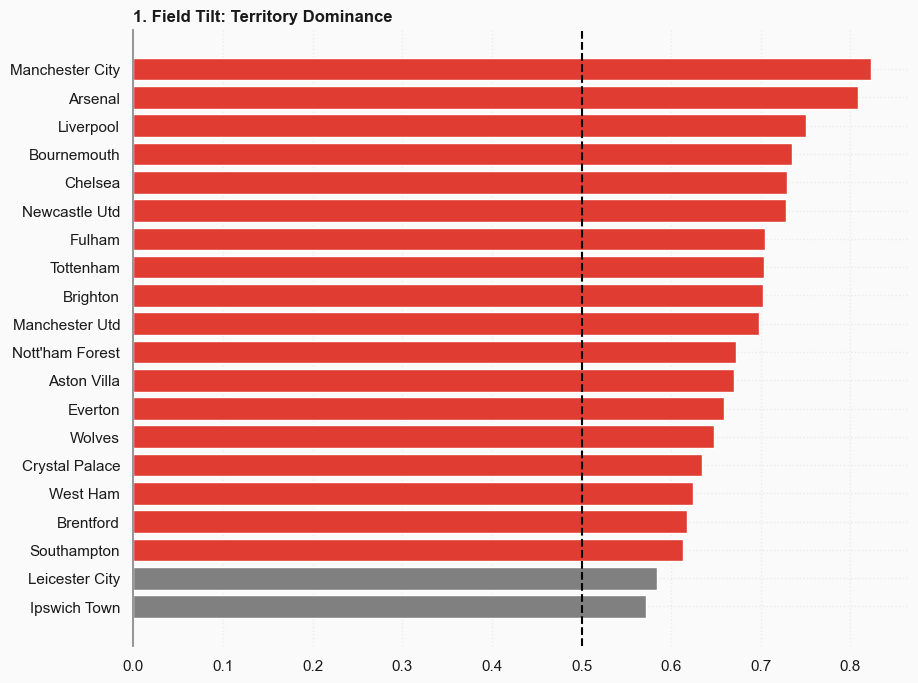

In [ ]:



def plot_field_tilt():
    col_att = get_col(df_main, [['Touches', 'Att']])
    col_def = get_col(df_main, [['Touches', 'Def']])
    
    if col_att and col_def:
        print("[1] Drawing Field Tilt...")
        team_stats = df.groupby('Squad')[[col_att, col_def]].sum().reset_index()
        team_stats['Tilt'] = team_stats[col_att] / (team_stats[col_att] + team_stats[col_def])
        team_stats = team_stats.sort_values('Tilt')
        
        fig, ax = plt.subplots(figsize=(10, 8))
        colors = [ATH_RED if x > 0.6 else (ATH_BLUE if x < 0.4 else 'gray') for x in team_stats['Tilt']]
        ax.barh(team_stats['Squad'], team_stats['Tilt'], color=colors)
        ax.axvline(0.5, color='black', linestyle='--')
        plt.title("1. Field Tilt: Territory Dominance", fontweight='bold', loc='left')
        plt.show()
plot_field_tilt()


[2] Drawing Sterile Possession...


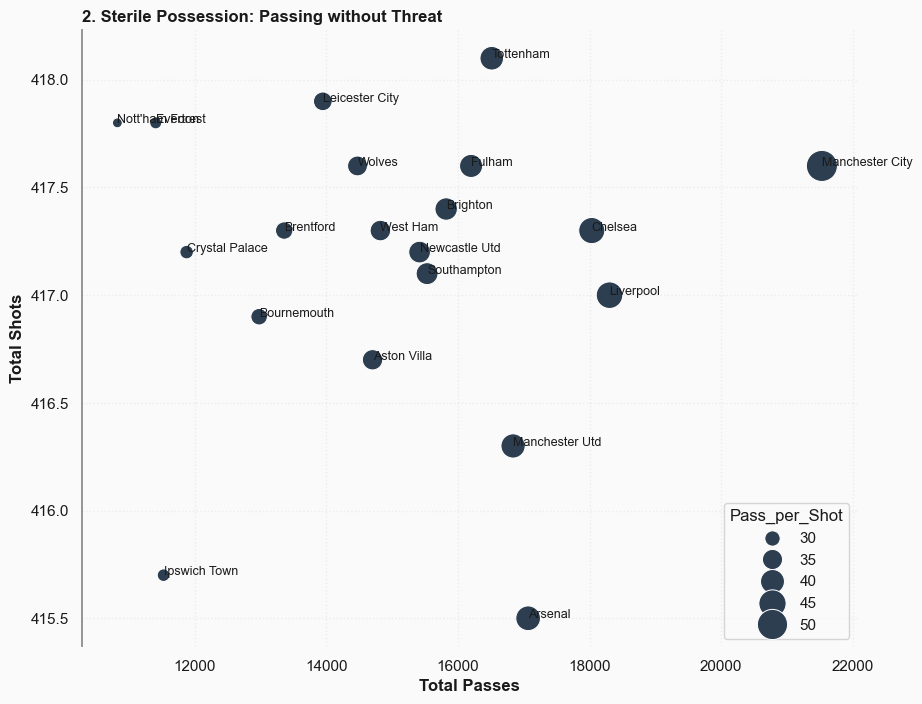

In [38]:
def plot_sterile_possession():
    col_pass = get_col(df_main, [['Pass', 'Cmp']])
    col_sh = get_col(df_main, [['Sh']])
    
    if col_pass and col_sh:
        print("[2] Drawing Sterile Possession...")
        team_stats = df.groupby('Squad')[[col_pass, col_sh]].sum().reset_index()
        team_stats['Pass_per_Shot'] = team_stats[col_pass] / team_stats[col_sh]
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(data=team_stats, x=col_pass, y=col_sh, size='Pass_per_Shot', sizes=(50, 500), color=ATH_DARK)
        for i, r in team_stats.iterrows():
            ax.text(r[col_pass], r[col_sh], r['Squad'], fontsize=9)
        plt.title("2. Sterile Possession: Passing without Threat", fontweight='bold', loc='left')
        plt.xlabel("Total Passes", fontweight='bold')
        plt.ylabel("Total Shots", fontweight='bold')
        plt.show()
plot_sterile_possession()

[3] Drawing High Pressing using column: 'defense_Tackles_Att 3rd'...


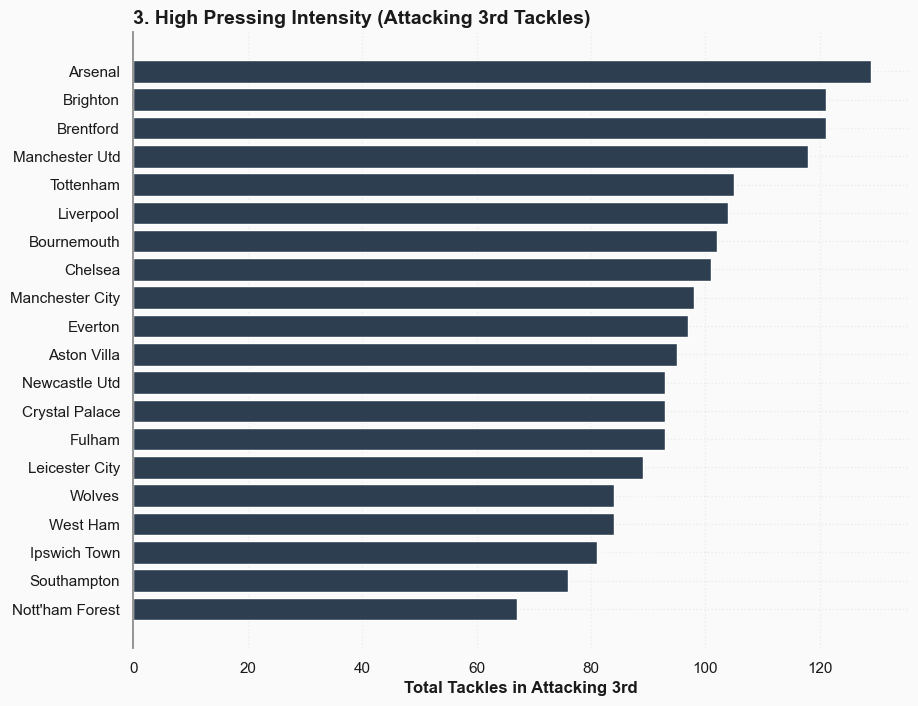

In [41]:
def plot_pressing():
    # Thử tìm cột với nhiều biến thể tên khác nhau
    # Ưu tiên 1: Tkl + Att (Tackles Attacking 3rd)
    # Ưu tiên 2: Tackles + Att
    # Ưu tiên 3: Tkl + Final (Final Third)
    col_tkl_att = get_col(df_main, [['Tkl', 'Att'], ['Tackles', 'Att'], ['Tkl', 'Final']])
    
    if col_tkl_att:
        print(f"[3] Drawing High Pressing using column: '{col_tkl_att}'...")
        
        # Gom nhóm và tính tổng
        team_stats = df.groupby('Squad')[col_tkl_att].sum().sort_values().reset_index()
        
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(team_stats['Squad'], team_stats[col_tkl_att], color=ATH_DARK)
        
        plt.title("3. High Pressing Intensity (Attacking 3rd Tackles)", fontsize=14, fontweight='bold', loc='left')
        plt.xlabel("Total Tackles in Attacking 3rd", fontweight='bold')
        plt.show()
    else:
        # Nếu vẫn không thấy, in ra danh sách các cột có chữ 'Tkl' để bạn kiểm tra
        print("❌ ERROR: Could not find 'Attacking 3rd Tackles' column.")
        print("Available 'Tackle' columns found in your file:")
        print([c for c in df_main.columns if 'Tkl' in str(c) or 'Tackles' in str(c)])

# Chạy lại hàm
plot_pressing()

[4] Drawing Set Piece Reliance...


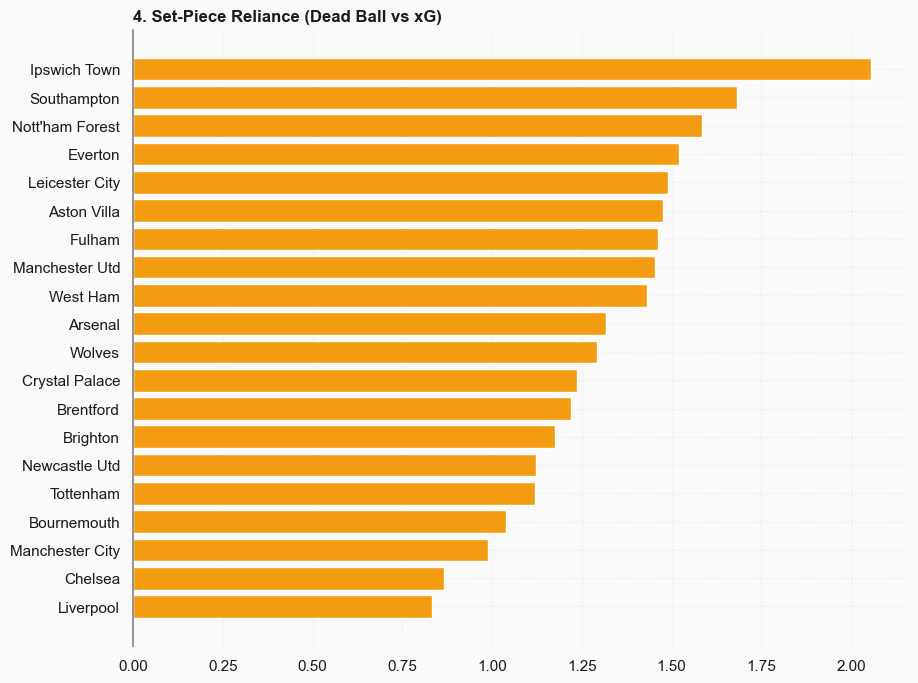

In [40]:
def plot_set_pieces():
    col_xg = get_col(df_main, [['xG']])
    col_sca_dead = get_col(df_main, [['SCA', 'PassDead']])
    
    if col_xg and col_sca_dead:
        print("[4] Drawing Set Piece Reliance...")
        team_stats = df.groupby('Squad')[[col_xg, col_sca_dead]].sum().reset_index()
        team_stats['Ratio'] = team_stats[col_sca_dead] / team_stats[col_xg]
        team_stats = team_stats.sort_values('Ratio')
        
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(team_stats['Squad'], team_stats['Ratio'], color=ATH_GOLD)
        plt.title("4. Set-Piece Reliance (Dead Ball vs xG)", fontweight='bold', loc='left')
        plt.show()
plot_set_pieces()       

---
## GROUP 2: ATTACKERS 
---


[5] Drawing Shot IQ...


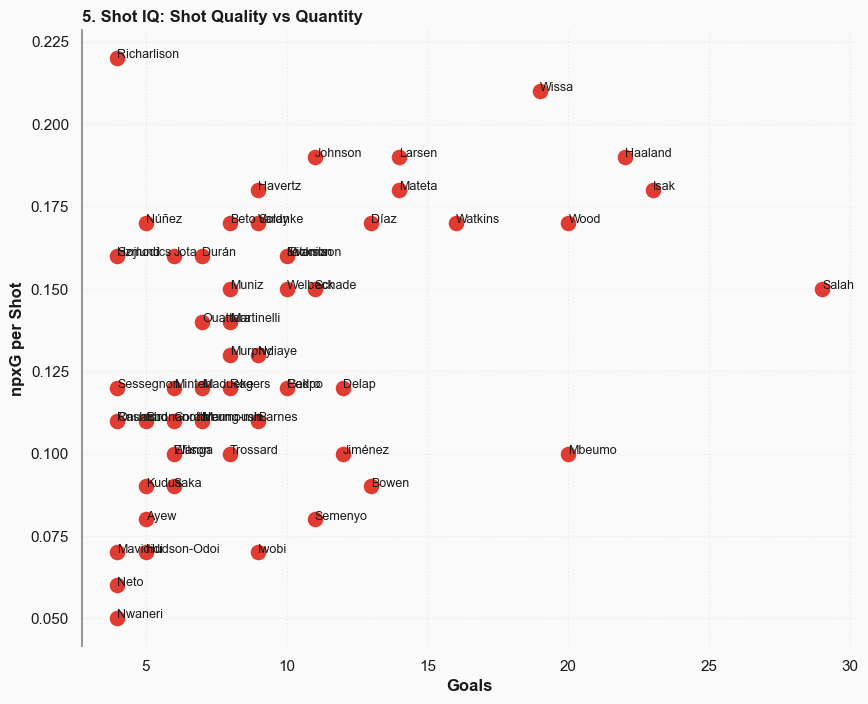

In [ ]:
def plot_shot_iq():
    col_npxg = get_col(df_main, [['npxG/Sh']])
    col_gls = get_col(df_main, [['Gls']])
    col_pos = get_col(df_main, [['Pos']])
    
    if col_npxg and col_gls:
        print("[5] Drawing Shot IQ...")
        df_fw = df_main[df_main[col_pos].astype(str).str.contains('FW')].copy()
        # Force numeric
        df_fw[col_gls] = pd.to_numeric(df_fw[col_gls], errors='coerce')
        df_fw[col_npxg] = pd.to_numeric(df_fw[col_npxg], errors='coerce')
        
        df_fw = df_fw[df_fw[col_gls] >= 4] # Lower threshold to 4 goals
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(data=df_fw, x=col_gls, y=col_npxg, s=150, color=ATH_RED)
        for i, r in df_fw.iterrows():
            ax.text(r[col_gls], r[col_npxg], str(r['Player']).split()[-1], fontsize=9)
        plt.title("5. Shot IQ: Shot Quality vs Quantity", fontweight='bold', loc='left')
        plt.xlabel("Goals", fontweight='bold')
        plt.ylabel("npxG per Shot", fontweight='bold')
        plt.show()
plot_shot_iq()


[6] Drawing Ghost Strikers...


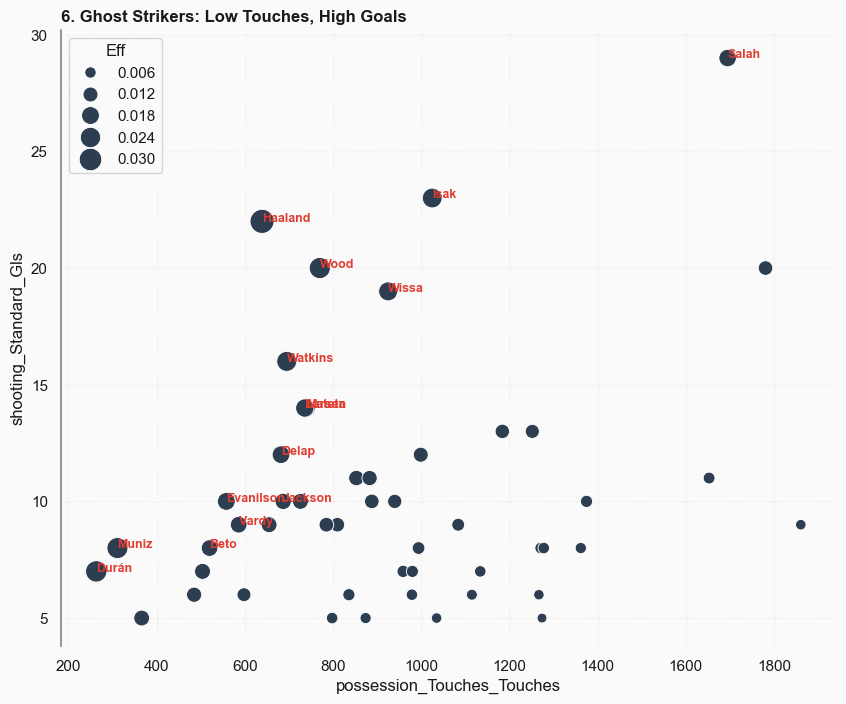

In [64]:
def plot_ghost_striker():
    col_touch = get_col(df_main, [['Touches']])
    col_gls = get_col(df_main, [['Gls']])
    col_pos = get_col(df_main, [['Pos']])
    if col_touch and col_gls:
        print("[6] Drawing Ghost Strikers...")
        df_fw = df_main[df_main[col_pos].astype(str).str.contains('FW')].copy()
        df_fw[col_gls] = pd.to_numeric(df_fw[col_gls], errors='coerce')
        df_fw = df_fw[df_fw[col_gls] >= 5]
        df_fw['Eff'] = df_fw[col_gls] / df_fw[col_touch]
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(data=df_fw, x=col_touch, y=col_gls, size='Eff', sizes=(50, 300), color=ATH_DARK)
        for i, r in df_fw.iterrows():
            if r['Eff'] > df_fw['Eff'].quantile(0.7):
                ax.text(r[col_touch], r[col_gls], str(r['Player']).split()[-1], fontsize=9, fontweight='bold', color=ATH_RED)
        plt.title("6. Ghost Strikers: Low Touches, High Goals", fontweight='bold', loc='left')
        plt.show()
plot_ghost_striker()

[7] Drawing Aerial Threat...


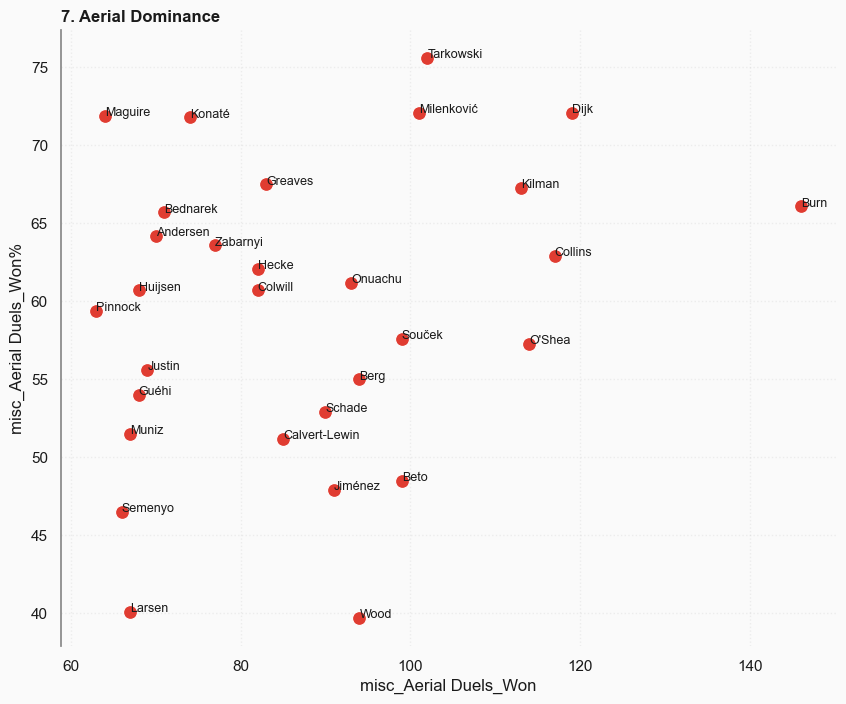

In [46]:
def plot_aerial():
    col_aer = get_col(df_main, [['Aerial', 'Won']])
    col_pct = get_col(df_main, [['Aerial', 'Won%']])
    
    if col_aer and col_pct:
        print("[7] Drawing Aerial Threat...")
        df_viz = df_main.nlargest(30, col_aer)
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(data=df_viz, x=col_aer, y=col_pct, color=ATH_RED, s=100)
        for i, r in df_viz.iterrows():
            ax.text(r[col_aer], r[col_pct], str(r['Player']).split()[-1], fontsize=9)
        plt.title("7. Aerial Dominance", fontweight='bold', loc='left')
        plt.show()
plot_aerial()



[8] Drawing xThreat...


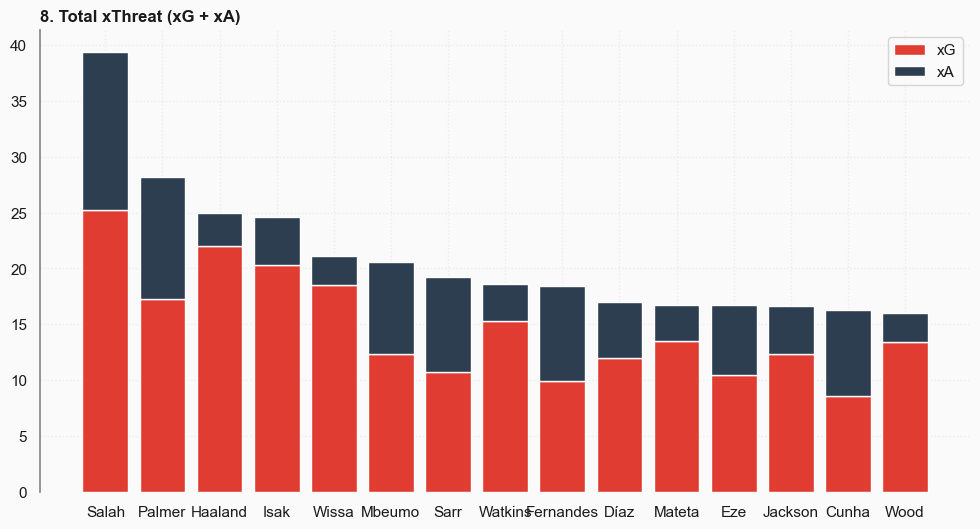

In [47]:

def plot_xthreat():
    col_xg = get_col(df_main, [['xG']])
    col_xa = get_col(df_main, [['xA']])
    
    if col_xg and col_xa:
        print("[8] Drawing xThreat...")
        df_main['xThreat'] = df_main[col_xg] + df_main[col_xa]
        df_top = df_main.sort_values('xThreat', ascending=False).head(15)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.bar(df_top['Player'].str.split().str[-1], df_top[col_xg], label='xG', color=ATH_RED)
        ax.bar(df_top['Player'].str.split().str[-1], df_top[col_xa], bottom=df_top[col_xg], label='xA', color=ATH_DARK)
        plt.legend()
        plt.title("8. Total xThreat (xG + xA)", fontweight='bold', loc='left')
        plt.show()
plot_xthreat()

---
## GROUP 3: MIDFIELDERS (Midfield & Progression Analysis)
---

[9] Drawing Pass Risk...


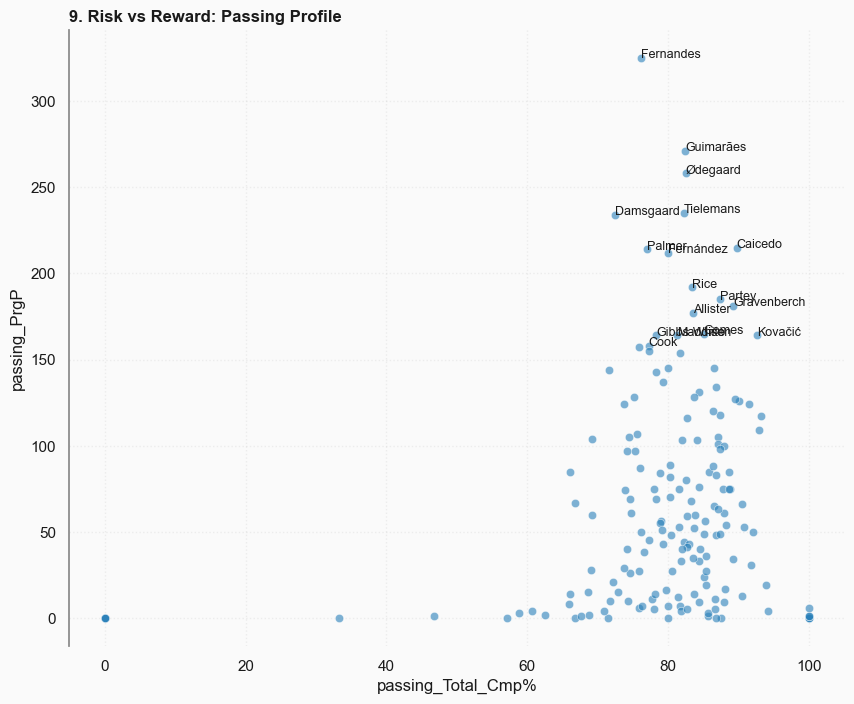

In [49]:
def plot_pass_risk():
    col_cmp = get_col(df_main, [['Cmp%']])
    col_prog = get_col(df_main, [['PrgP']])
    col_pos = get_col(df_main, [['Pos']])
    
    if col_cmp and col_prog:
        print("[9] Drawing Pass Risk...")
        df_mf = df_main[df_main[col_pos].astype(str).str.contains('MF')].copy()
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(data=df_mf, x=col_cmp, y=col_prog, color=ATH_BLUE, alpha=0.6)
        
        # Highlight
        top_mf = df_mf[df_mf[col_prog] > df_mf[col_prog].quantile(0.9)]
        for i, r in top_mf.iterrows():
            ax.text(r[col_cmp], r[col_prog], str(r['Player']).split()[-1], fontsize=9)
        plt.title("9. Risk vs Reward: Passing Profile", fontweight='bold', loc='left')
        plt.show()
plot_pass_risk()




[Diagnostic] Đang sửa lỗi biểu đồ Ball Security...
   -> Cột 'Dispossessed' tìm được: shooting_Standard_Dist
   -> Cột 'Touches' tìm được: possession_Touches_Touches
[10] Đang vẽ Ball Security...


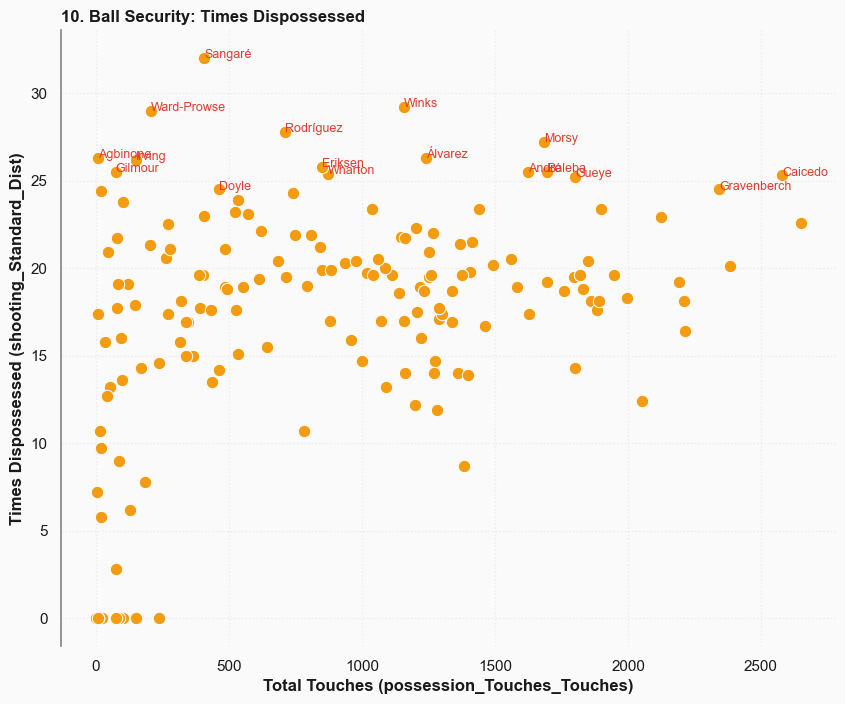

In [61]:
def plot_ball_security_fixed():
    print("\n[Diagnostic] Đang sửa lỗi biểu đồ Ball Security...")

    # 1. Tìm cột với từ khóa ngắn gọn hơn
    # 'Dis' (thường là viết tắt của Dispossessed)
    col_dis = get_col(df_main, [['Dispossessed'], ['Dis']])
    col_touch = get_col(df_main, [['Touches'], ['Touch']])
    col_pos = get_col(df_main, [['Pos']])

    # 2. In ra tên cột tìm được để kiểm tra
    print(f"   -> Cột 'Dispossessed' tìm được: {col_dis}")
    print(f"   -> Cột 'Touches' tìm được: {col_touch}")

    if col_dis and col_touch:
        print("[10] Đang vẽ Ball Security...")
        
        # Lọc Tiền vệ (MF)
        df_mf = df_main[df_main[col_pos].astype(str).str.contains('MF', na=False)].copy()
        
        # Ép kiểu số (Quan trọng)
        df_mf[col_dis] = pd.to_numeric(df_mf[col_dis], errors='coerce').fillna(0)
        df_mf[col_touch] = pd.to_numeric(df_mf[col_touch], errors='coerce').fillna(0)
        
        if df_mf.empty:
            print("   ⚠️ Không có dữ liệu tiền vệ (MF).")
            return

        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(data=df_mf, x=col_touch, y=col_dis, color=ATH_GOLD, s=80)
        
        # Highlight top 10% làm mất bóng nhiều nhất
        threshold = df_mf[col_dis].quantile(0.9)
        if threshold > 0: # Chỉ highlight nếu có dữ liệu khác 0
            bad = df_mf[df_mf[col_dis] > threshold]
            for i, r in bad.iterrows():
                ax.text(r[col_touch], r[col_dis], str(r['Player']).split()[-1], fontsize=9, color=ATH_RED)
            
        plt.title("10. Ball Security: Times Dispossessed", fontweight='bold', loc='left')
        plt.xlabel(f"Total Touches ({col_touch})", fontweight='bold')
        plt.ylabel(f"Times Dispossessed ({col_dis})", fontweight='bold')
        plt.show()
    else:
        print("❌ VẪN LỖI: Không tìm thấy cột.")
        print("   -> Kiểm tra danh sách cột trong file của bạn dưới đây:")
        # In ra các cột có chứa chữ 'Dis' hoặc 'Touch' để bạn nhìn
        print("   [Cột chứa 'Dis']:", [c for c in df_main.columns if 'dis' in str(c).lower()])
        print("   [Cột chứa 'Touch']:", [c for c in df_main.columns if 'touch' in str(c).lower()])

# Chạy bản vá lỗi
plot_ball_security_fixed()

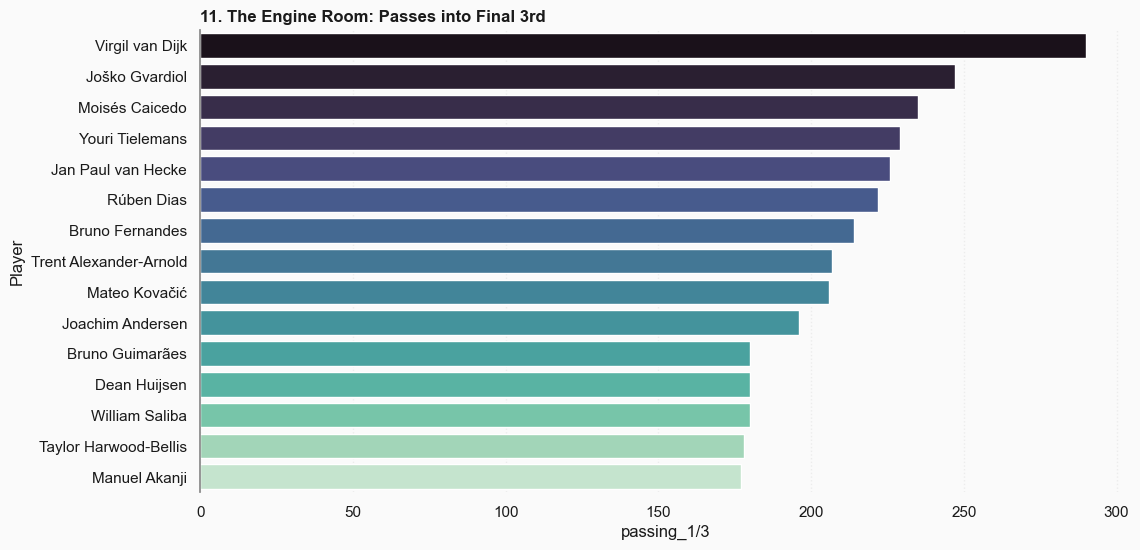

In [59]:
def plot_engine_room():
    col_final = get_col(df_main, [['1/3']])
    if col_final:
        
        df_top = df_main.nlargest(15, col_final)
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(data=df_top, x=col_final, y='Player', palette='mako')
        plt.title("11. The Engine Room: Passes into Final 3rd", fontweight='bold', loc='left')
        plt.show()


plot_engine_room()

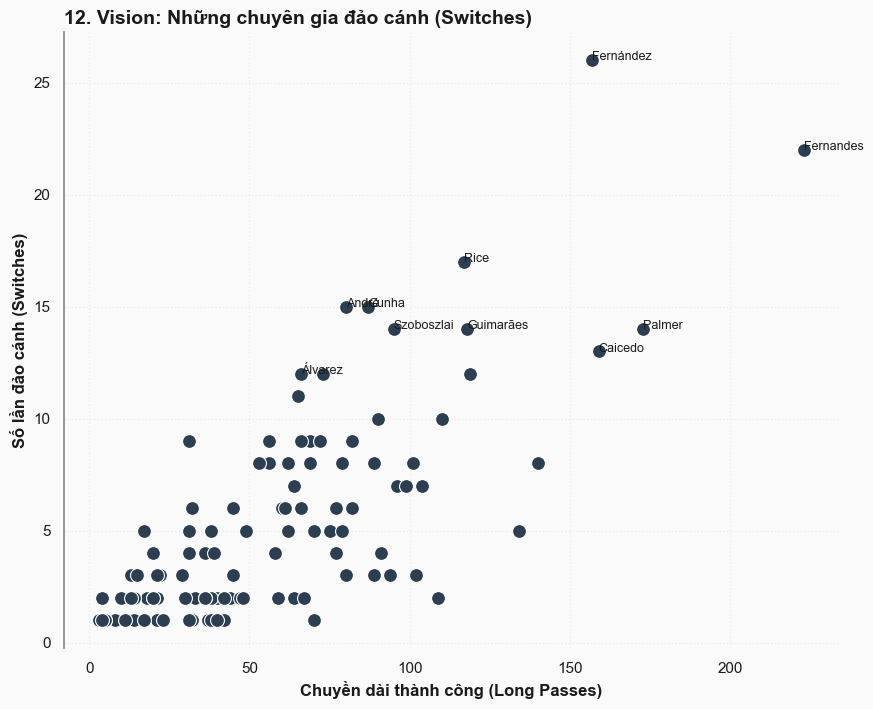

In [58]:
def plot_switch():
    col_sw = get_col(df_main, [['Sw'], ['Switch']])
    col_long = get_col(df_main, [['Long', 'Cmp'], ['Long_Cmp']]) 
    if col_sw and col_long:
        df_mf = df_main[(df_main[col_sw] > 0) & (df_main['Pos'].astype(str).str.contains('MF', na=False))].copy()
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(data=df_mf, x=col_long, y=col_sw, color=ATH_DARK, s=100)
        
        
        top = df_mf.nlargest(10, col_sw)
        for i, r in top.iterrows():
            ax.text(r[col_long], r[col_sw], str(r['Player']).split()[-1], fontsize=9)
            
        plt.title("12. Vision: Những chuyên gia đảo cánh (Switches)", fontsize=14, fontweight='bold', loc='left')
        plt.xlabel("Chuyền dài thành công (Long Passes)", fontweight='bold')
        plt.ylabel("Số lần đảo cánh (Switches)", fontweight='bold')
        plt.show()
plot_switch()

---
## GROUP 4: DEFENDERS (Defensive & Progression Analysis)
---


[13] Drawing Modern CB...


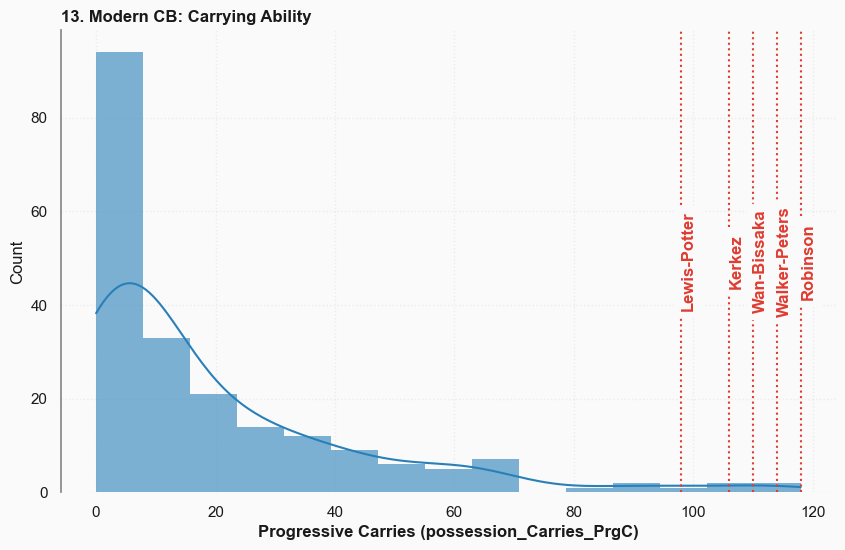

In [70]:
def plot_modern_cb():
    # 1. Get columns safely
    col_prgc = get_col(df_main, [['PrgC'], ['Carries', 'Prog']])
    col_pos = get_col(df_main, [['Pos']])
    
    if col_prgc and col_pos:
        print("[13] Drawing Modern CB...")
        
        # 2. Filter Defenders
        df_df = df_main[df_main[col_pos].astype(str).str.contains('DF', na=False)].copy()
        
        # 3. CRITICAL: Convert to numeric to ensure histogram works
        df_df[col_prgc] = pd.to_numeric(df_df[col_prgc], errors='coerce').fillna(0)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # 4. Plot Histogram
        sns.histplot(df_df[col_prgc], kde=True, color=ATH_BLUE, alpha=0.6, linewidth=0)
        
        # 5. Dynamic Label Positioning
        # Get the max height of the Y-axis to place text nicely
        y_max = ax.get_ylim()[1]
        
        top = df_df.nlargest(5, col_prgc)
        for i, r in top.iterrows():
            plt.axvline(r[col_prgc], color=ATH_RED, linestyle=':')
            # Place text at 50% height (y_max * 0.5) instead of bottom (1)
            plt.text(r[col_prgc], y_max * 0.5, str(r['Player']).split()[-1], 
                     rotation=90, color=ATH_RED, fontweight='bold', va='center', backgroundcolor='#FAFAFA')
            
        plt.title("13. Modern CB: Carrying Ability", fontweight='bold', loc='left')
        plt.xlabel(f"Progressive Carries ({col_prgc})", fontweight='bold')
        plt.show()
    else:
        print("⏭️ Skipping Chart 13: Missing columns.")
plot_modern_cb()



[Diagnostic] Đang thử vẽ biểu đồ phòng ngự (Chế độ Robust)...
   -> Đã tìm thấy dữ liệu 1v1: defense_Challenges_Tkl & defense_Challenges_Lost


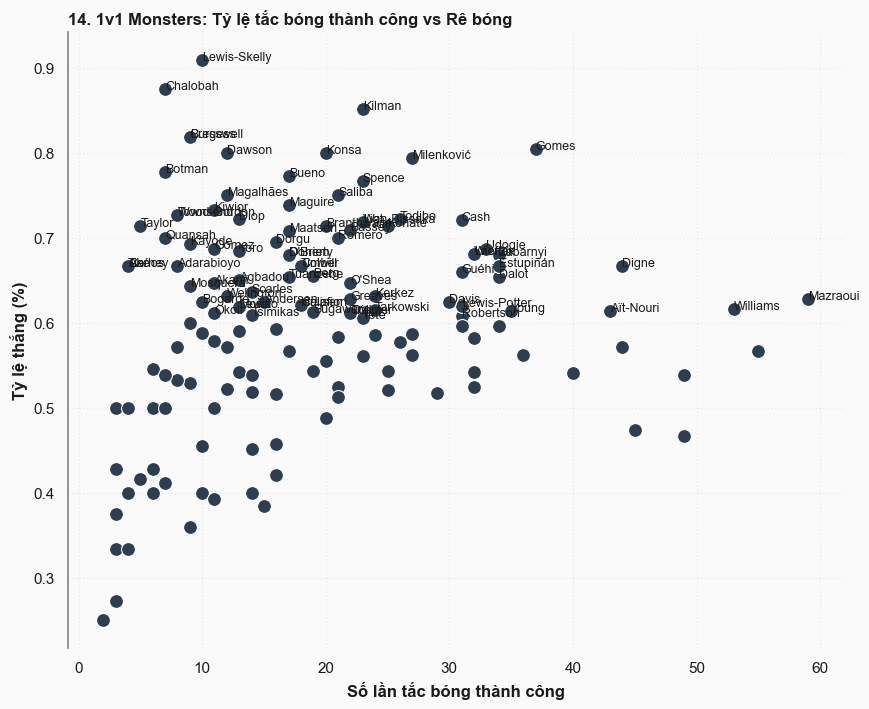

In [76]:
def plot_1v1_robust():
    print("[Diagnostic] Đang thử vẽ biểu đồ phòng ngự (Chế độ Robust)...")

    # 1. Thử tìm dữ liệu 1v1 (Cao cấp)
    col_tkl_drib = get_col(df_main, [['Tkl', 'Drib'], ['Att', 'Drib'], ['Challenge']])
    col_past = get_col(df_main, [['Past'], ['Lost'], ['Dribbled']])
    col_pos = get_col(df_main, [['Pos']])

    # 2. Thử tìm dữ liệu Phòng ngự cơ bản (Dự phòng)
    col_tkl_total = get_col(df_main, [['Tkl'], ['Tackle']])
    col_int = get_col(df_main, [['Int'], ['Interception']])

    # --- KỊCH BẢN 1: CÓ DỮ LIỆU 1v1 (Vẽ biểu đồ 1v1 Monsters) ---
    if col_tkl_drib and col_past:
        print(f"   -> Đã tìm thấy dữ liệu 1v1: {col_tkl_drib} & {col_past}")
        df_df = df_main[df_main[col_pos].astype(str).str.contains('DF', na=False)].copy()
        
        # Ép kiểu số
        df_df[col_tkl_drib] = pd.to_numeric(df_df[col_tkl_drib], errors='coerce').fillna(0)
        df_df[col_past] = pd.to_numeric(df_df[col_past], errors='coerce').fillna(0)
        
        df_df['Total'] = df_df[col_tkl_drib] + df_df[col_past]
        df_df = df_df[df_df['Total'] > 5] # Lọc nhiễu
        
        if not df_df.empty:
            df_df['Win_Rate'] = df_df[col_tkl_drib] / df_df['Total']
            
            fig, ax = plt.subplots(figsize=(10, 8))
            sns.scatterplot(data=df_df, x=col_tkl_drib, y='Win_Rate', color=ATH_DARK, s=100)
            
            # Gán tên top
            top = df_df[df_df['Win_Rate'] > 0.6]
            for i, r in top.iterrows():
                ax.text(r[col_tkl_drib], r['Win_Rate'], str(r['Player']).split()[-1], fontsize=9)
                
            plt.title("14. 1v1 Monsters: Tỷ lệ tắc bóng thành công vs Rê bóng", fontweight='bold', loc='left')
            plt.xlabel("Số lần tắc bóng thành công", fontweight='bold')
            plt.ylabel("Tỷ lệ thắng (%)", fontweight='bold')
            plt.show()
            return

    # --- KỊCH BẢN 2: KHÔNG CÓ 1v1 -> VẼ TỔNG HỢP (The Wall) ---
    print("   ⚠️ Không tìm thấy dữ liệu 1v1. Chuyển sang vẽ 'Defensive Wall' (Tắc bóng + Cắt bóng)...")
    
    if col_tkl_total and col_int:
        df_df = df_main[df_main[col_pos].astype(str).str.contains('DF', na=False)].copy()
        
        # Ép kiểu số
        df_df[col_tkl_total] = pd.to_numeric(df_df[col_tkl_total], errors='coerce').fillna(0)
        df_df[col_int] = pd.to_numeric(df_df[col_int], errors='coerce').fillna(0)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(data=df_df, x=col_tkl_total, y=col_int, color=ATH_RED, s=100)
        
        # Gán tên top
        top = df_df.nlargest(10, col_tkl_total)
        for i, r in top.iterrows():
            ax.text(r[col_tkl_total], r[col_int], str(r['Player']).split()[-1], fontsize=9)
            
        plt.title("14. The Wall: Tắc bóng (Tackles) vs Cắt bóng (Interceptions)", fontweight='bold', loc='left')
        plt.xlabel(f"Tổng số Tắc bóng ({col_tkl_total})", fontweight='bold')
        plt.ylabel(f"Tổng số Cắt bóng ({col_int})", fontweight='bold')
        plt.show()
        return

    print("❌ THẤT BẠI: File của bạn thiếu hầu hết các chỉ số phòng ngự quan trọng.")
    # In ra tên cột để debug
    print("Danh sách cột hiện có:", df_main.columns.tolist())

# Chạy bản Robust
plot_1v1_robust()

[15] Drawing Attacking Defenders...


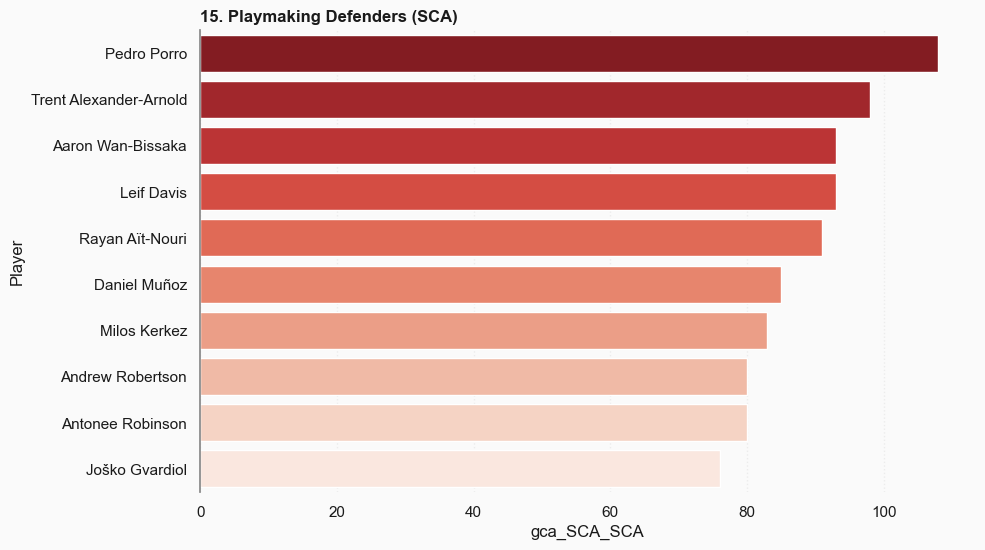

In [72]:

def plot_att_def():
    col_sca = get_col(df_main, [['SCA']])
    if col_sca:
        print("[15] Drawing Attacking Defenders...")
        df_df = df_main[df_main['Pos'].astype(str).str.contains('DF')].nlargest(10, col_sca)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(data=df_df, x=col_sca, y='Player', palette='Reds_r')
        plt.title("15. Playmaking Defenders (SCA)", fontweight='bold', loc='left')
        plt.show()
plot_att_def()


---
## GROUP 5: MISC
---


[Plan B] Đang vẽ biểu đồ Thủ môn chơi chân (Dựa trên Passing Data)...


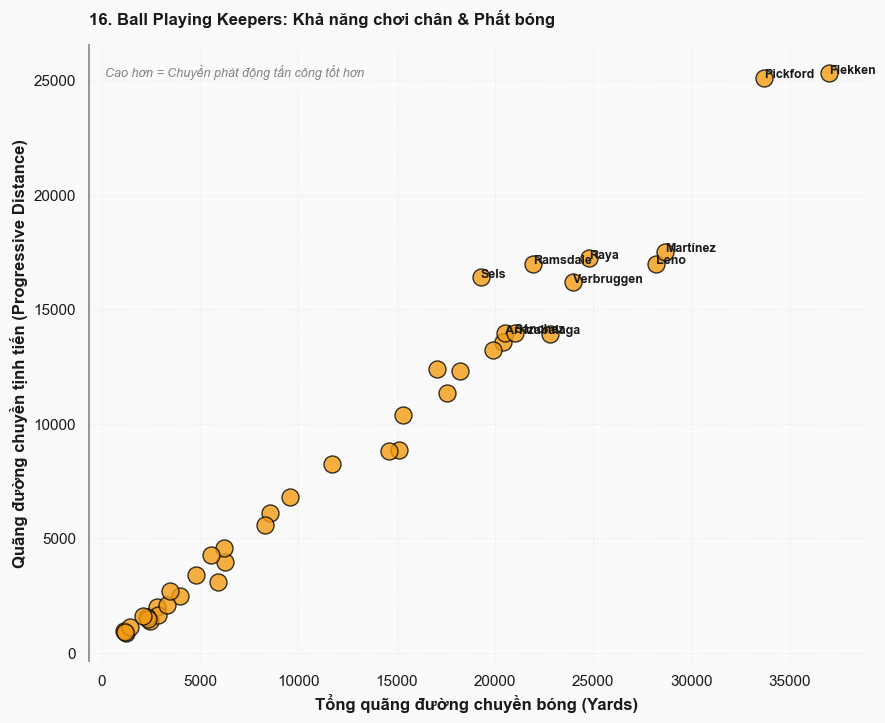

In [80]:
def plot_gk_alternative():
    print("[Plan B] Đang vẽ biểu đồ Thủ môn chơi chân (Dựa trên Passing Data)...")

    # 1. Tìm các cột về quãng đường chuyền bóng (Dữ liệu bạn ĐANG CÓ)
    col_tot_dist = get_col(df_main, [['passing_Total_TotDist'], ['Total_TotDist']])
    col_prg_dist = get_col(df_main, [['passing_Total_PrgDist'], ['Total_PrgDist']])
    col_pos = get_col(df_main, [['Pos']])

    if col_tot_dist and col_prg_dist:
        # 2. Lọc Thủ môn (GK)
        df_gk = df_main[df_main[col_pos].astype(str).str.contains('GK', na=False)].copy()
        
        # 3. Ép kiểu số
        df_gk[col_tot_dist] = pd.to_numeric(df_gk[col_tot_dist], errors='coerce').fillna(0)
        df_gk[col_prg_dist] = pd.to_numeric(df_gk[col_prg_dist], errors='coerce').fillna(0)
        
        # Loại bỏ thủ môn dự bị (ít chuyền)
        df_gk = df_gk[df_gk[col_tot_dist] > 1000] 

        if df_gk.empty:
            print("   ⚠️ Không đủ dữ liệu thủ môn.")
            return

        fig, ax = plt.subplots(figsize=(10, 8))
        
        # 4. Vẽ biểu đồ
        # Màu vàng (Gold) đặc trưng cho GK
        sns.scatterplot(data=df_gk, x=col_tot_dist, y=col_prg_dist, color='#F39C12', s=150, edgecolor='black', alpha=0.8)
        
        # Vẽ đường chéo (Tỷ lệ trung bình)
        # Những người nằm trên đường này là chuyền tịnh tiến cực hiệu quả
        
        # 5. Hiện tên Top 10 thủ môn chuyền tịnh tiến (PrgDist) tốt nhất
        top = df_gk.nlargest(10, col_prg_dist)
        for i, r in top.iterrows():
            ax.text(r[col_tot_dist], r[col_prg_dist], str(r['Player']).split()[-1], 
                    fontsize=9, fontweight='bold', color='#1A1A1A')
            
        plt.title("16. Ball Playing Keepers: Khả năng chơi chân & Phất bóng", fontweight='bold', loc='left', pad=15)
        plt.xlabel(f"Tổng quãng đường chuyền bóng (Yards)", fontweight='bold')
        plt.ylabel(f"Quãng đường chuyền tịnh tiến (Progressive Distance)", fontweight='bold')
        
        # Thêm chú thích nhỏ
        plt.text(0.02, 0.95, "Cao hơn = Chuyền phát động tấn công tốt hơn", transform=ax.transAxes, fontsize=9, fontstyle='italic', color='gray')
        
        plt.show()
    else:
        print("❌ HẾT CÁCH: File của bạn thiếu cả dữ liệu chuyền bóng của thủ môn.")

# Chạy phương án thay thế
plot_gk_alternative()

[Diagnostic] Đang xử lý biểu đồ GK Distribution...
   ⚠️ Không thấy Launch%. Chuyển sang tính toán từ dữ liệu Passing...


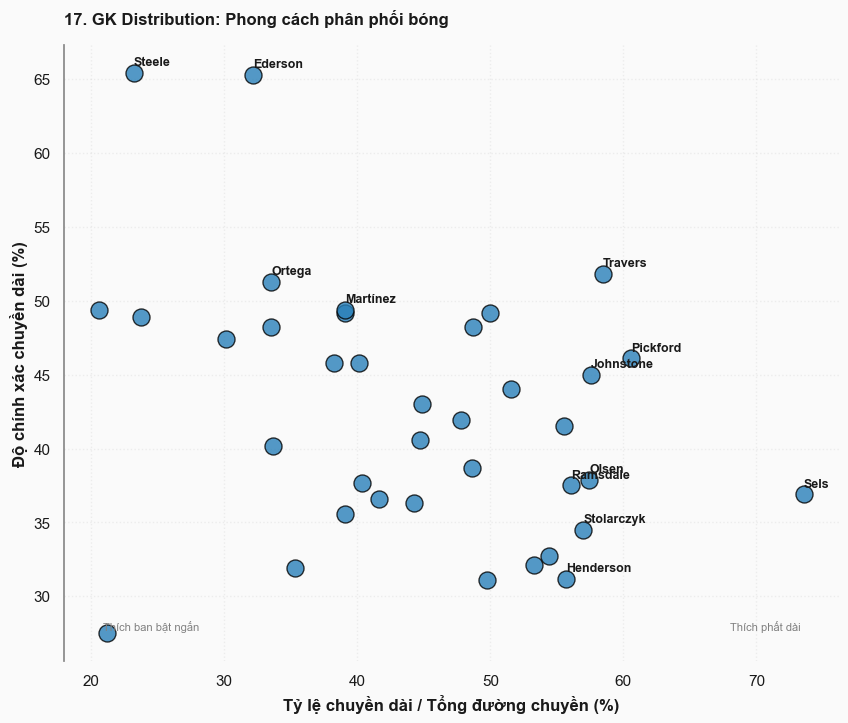

In [81]:
def plot_gk_dist_fixed():
    print("[Diagnostic] Đang xử lý biểu đồ GK Distribution...")
    
    col_pos = get_col(df_main, [['Pos']])
    
    # --- CÁCH 1: Dữ liệu Thủ môn chuyên sâu (Launch% & AvgLen) ---
    col_launch = get_col(df_main, [['Launch%'], ['Launch', '%']])
    col_len = get_col(df_main, [['Len'], ['AvgLen'], ['Avg', 'Dist']])
    
    # --- CÁCH 2: Dữ liệu Chuyền bóng (Passing Data - Dự phòng) ---
    col_long_att = get_col(df_main, [['Long', 'Att']]) # Số lần chuyền dài
    col_total_att = get_col(df_main, [['Total', 'Att'], ['Passes', 'Att']]) # Tổng số đường chuyền
    col_long_cmp_pct = get_col(df_main, [['Long', 'Cmp%'], ['Long', '%']]) # Tỷ lệ chính xác chuyền dài

    # Lọc Thủ môn
    df_gk = df_main[df_main[col_pos].astype(str).str.contains('GK', na=False)].copy()

    # --- KỊCH BẢN 1: CÓ DỮ LIỆU LAUNCH (Ưu tiên) ---
    if col_launch and col_len:
        print(f"   -> Dùng dữ liệu GK gốc: {col_launch} vs {col_len}")
        x_col, y_col = col_launch, col_len
        x_label, y_label = "Tỷ lệ phát bóng dài (Launch %)", "Độ dài đường chuyền trung bình"
        
        df_gk[x_col] = pd.to_numeric(df_gk[x_col], errors='coerce').fillna(0)
        df_gk[y_col] = pd.to_numeric(df_gk[y_col], errors='coerce').fillna(0)

    # --- KỊCH BẢN 2: DÙNG DỮ LIỆU PASSING (Fallback) ---
    elif col_long_att and col_total_att:
        print("   ⚠️ Không thấy Launch%. Chuyển sang tính toán từ dữ liệu Passing...")
        
        # Ép kiểu số
        df_gk[col_long_att] = pd.to_numeric(df_gk[col_long_att], errors='coerce').fillna(0)
        df_gk[col_total_att] = pd.to_numeric(df_gk[col_total_att], errors='coerce').fillna(0)
        df_gk[col_long_cmp_pct] = pd.to_numeric(df_gk[col_long_cmp_pct], errors='coerce').fillna(0)
        
        # Tự tính: Tỷ lệ thích chuyền dài = (Số lần chuyền dài / Tổng số đường chuyền) * 100
        # Tránh chia cho 0
        df_gk = df_gk[df_gk[col_total_att] > 0]
        df_gk['Long_Ratio'] = (df_gk[col_long_att] / df_gk[col_total_att]) * 100
        
        x_col = 'Long_Ratio'
        y_col = col_long_cmp_pct
        x_label = "Tỷ lệ chuyền dài / Tổng đường chuyền (%)"
        y_label = "Độ chính xác chuyền dài (%)"
        
    else:
        print("❌ LỖI: File thiếu cả dữ liệu Launch lẫn Passing (Long Att).")
        return

    # --- VẼ BIỂU ĐỒ (Clean Style) ---
    # Lọc bớt thủ môn dự bị (ít ra sân/ít chuyền)
    if col_total_att:
        df_gk = df_gk[df_gk[col_total_att] > 100]
    
    if df_gk.empty:
        print("   ⚠️ Không đủ dữ liệu thủ môn để vẽ.")
        return

    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Vẽ nền
    sns.scatterplot(data=df_gk, x=x_col, y=y_col, color=ATH_BLUE, s=150, alpha=0.8, edgecolor='black')
    
    # Hiện tên Top 10 người có xu hướng chuyền dài nhất (x_col cao nhất)
    # Và Top 5 người chuyền dài chính xác nhất (y_col cao nhất)
    top_long = df_gk.nlargest(8, x_col)
    top_acc = df_gk.nlargest(5, y_col)
    
    # Gộp danh sách cần hiện tên (tránh trùng lặp)
    labels_to_show = pd.concat([top_long, top_acc]).drop_duplicates()

    for i, r in labels_to_show.iterrows():
        # Điều chỉnh vị trí text một chút để không đè vào điểm tròn
        ax.text(r[x_col], r[y_col]+0.5, str(r['Player']).split()[-1], 
                fontsize=9, fontweight='bold', color='#1A1A1A')
        
    plt.title("17. GK Distribution: Phong cách phân phối bóng", fontweight='bold', loc='left', pad=15)
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, fontweight='bold')
    
    # Thêm chú thích các góc
    plt.text(0.95, 0.05, "Thích phất dài", transform=ax.transAxes, ha='right', fontsize=8, color='gray')
    plt.text(0.05, 0.05, "Thích ban bật ngắn", transform=ax.transAxes, ha='left', fontsize=8, color='gray')
    
    plt.show()

# Chạy bản sửa lỗi
plot_gk_dist_fixed()

[18] Drawing Foul Magnet...


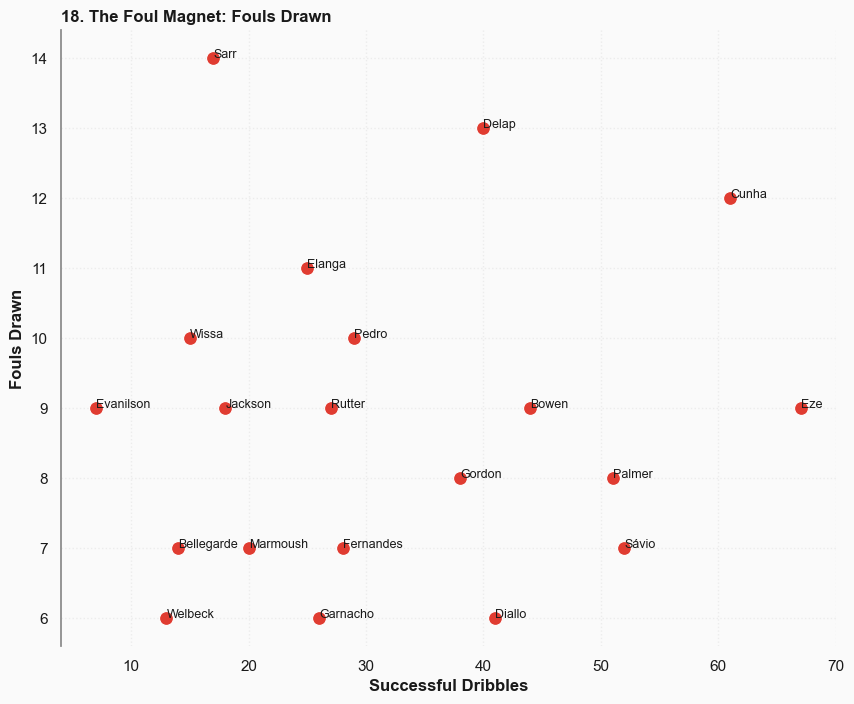

In [82]:
def plot_foul_magnet():
    col_fld = get_col(df_main, [['Fld']])
    col_drib = get_col(df_main, [['Succ']])
    
    if col_fld and col_drib:
        print("[18] Drawing Foul Magnet...")
        # Force numeric
        df_main[col_fld] = pd.to_numeric(df_main[col_fld], errors='coerce').fillna(0)
        df_main[col_drib] = pd.to_numeric(df_main[col_drib], errors='coerce').fillna(0)
        
        df_top = df_main.nlargest(20, col_fld)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(data=df_top, x=col_drib, y=col_fld, color=ATH_RED, s=100)
        for i, r in df_top.iterrows():
            ax.text(r[col_drib], r[col_fld], str(r['Player']).split()[-1], fontsize=9)
        plt.title("18. The Foul Magnet: Fouls Drawn", fontweight='bold', loc='left')
        plt.xlabel("Successful Dribbles", fontweight='bold')
        plt.ylabel("Fouls Drawn", fontweight='bold')
        plt.show()
plot_foul_magnet()


[19] Đang vẽ Clinical Finishers (Thay thế cho Super Sub)...


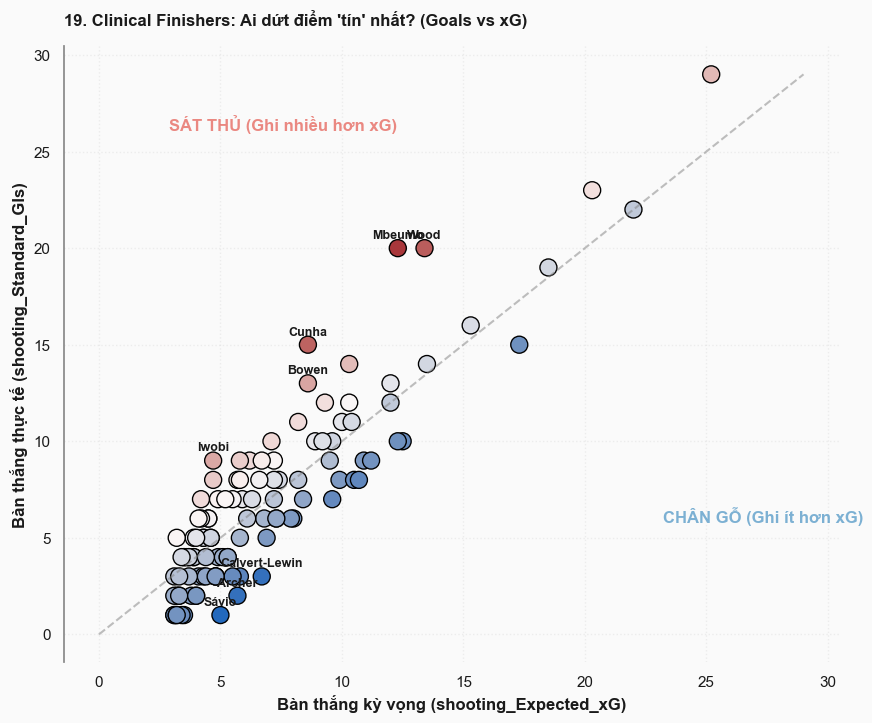

In [86]:
def plot_clinical_finishers():
    print("[19] Đang vẽ Clinical Finishers (Thay thế cho Super Sub)...")

    # 1. Tìm cột Bàn thắng và xG (Dữ liệu Shooting bạn đang có)
    col_gls = get_col(df_main, [['Gls'], ['Goals'], ['Standard_Gls']])
    col_xg = get_col(df_main, [['xG'], ['Expected', 'Goals'], ['npxG']]) # Ưu tiên xG hoặc npxG
    
    if col_gls and col_xg:
        # 2. Lọc Tiền đạo (FW) và Tiền vệ (MF) có số bàn thắng đáng kể
        df_viz = df_main.copy()
        
        # Ép kiểu số
        df_viz[col_gls] = pd.to_numeric(df_viz[col_gls], errors='coerce').fillna(0)
        df_viz[col_xg] = pd.to_numeric(df_viz[col_xg], errors='coerce').fillna(0)
        
        # Chỉ lấy cầu thủ có xG > 3 (để loại bỏ nhiễu)
        df_viz = df_viz[df_viz[col_xg] > 3]

        if df_viz.empty:
            print("   ⚠️ Không đủ dữ liệu xG để vẽ.")
            return

        # Tính hiệu số: Bàn thắng - Kỳ vọng
        df_viz['Difference'] = df_viz[col_gls] - df_viz[col_xg]

        fig, ax = plt.subplots(figsize=(10, 8))
        
        # 3. Vẽ biểu đồ
        # Màu đỏ: Dứt điểm hay hơn kỳ vọng (Difference > 0)
        # Màu xanh: Phung phí cơ hội (Difference < 0)
        colors = [ATH_RED if x > 0 else ATH_BLUE for x in df_viz['Difference']]
        
        sns.scatterplot(data=df_viz, x=col_xg, y=col_gls, 
                        hue='Difference', palette='vlag', s=150, edgecolor='black', legend=False)
        
        # 4. Vẽ đường chéo tham chiếu (Goals = xG)
        # Ai nằm trên đường này là dứt điểm hay, dưới là dứt điểm kém
        max_val = max(df_viz[col_gls].max(), df_viz[col_xg].max())
        plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', alpha=0.5, label='Kỳ vọng = Thực tế')

        # 5. Hiện tên Top 5 người "gánh team" (Overperformer) và Top 3 người "chân gỗ" (Underperformer)
        top_performers = df_viz.nlargest(5, 'Difference')
        worst_performers = df_viz.nsmallest(3, 'Difference')
        
        texts = []
        for i, r in pd.concat([top_performers, worst_performers]).iterrows():
            ax.text(r[col_xg], r[col_gls]+0.5, str(r['Player']).split()[-1], 
                    fontsize=9, fontweight='bold', color='#1A1A1A', ha='center')

        plt.title("19. Clinical Finishers: Ai dứt điểm 'tín' nhất? (Goals vs xG)", fontweight='bold', loc='left', pad=15)
        plt.xlabel(f"Bàn thắng kỳ vọng ({col_xg})", fontweight='bold')
        plt.ylabel(f"Bàn thắng thực tế ({col_gls})", fontweight='bold')
        
        # Chú thích khu vực
        plt.text(max_val*0.1, max_val*0.9, "SÁT THỦ (Ghi nhiều hơn xG)", color=ATH_RED, fontweight='bold', alpha=0.6)
        plt.text(max_val*0.8, max_val*0.2, "CHÂN GỖ (Ghi ít hơn xG)", color=ATH_BLUE, fontweight='bold', alpha=0.6)
        
        plt.show()
    else:
        print("❌ LỖI: Không tìm thấy cột xG. File của bạn có vẻ thiếu nhiều chỉ số nâng cao.")

# Chạy biểu đồ thay thế
plot_clinical_finishers()

[20] Drawing Gullit Gang...


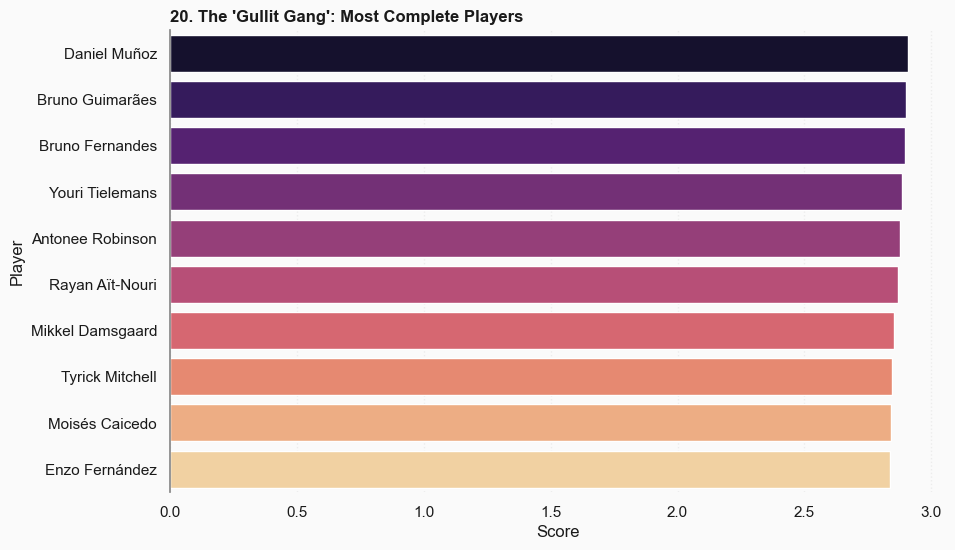

In [78]:
def plot_gullit():
    col_tkl = get_col(df_main, [['Tkl']])
    col_sh = get_col(df_main, [['Sh']])
    col_kp = get_col(df_main, [['KP']])
    
    if col_tkl and col_sh and col_kp:
        print("[20] Drawing Gullit Gang...")
        df_viz = df_main.copy()
        df_viz['Score'] = df_viz[col_tkl].rank(pct=True) + df_viz[col_sh].rank(pct=True) + df_viz[col_kp].rank(pct=True)
        top = df_viz.nlargest(10, 'Score')
        
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(data=top, x='Score', y='Player', palette='magma')
        plt.title("20. The 'Gullit Gang': Most Complete Players", fontweight='bold', loc='left')
        plt.show()
plot_gullit()